In [1]:
import numpy as np
from astropy.table import Table
from astropy import table
from astropy.io.votable import parse
from astropy.constants import G, M_sun, pc, R_sun
from dust_extinction.parameter_averages import G23
import astropy.units as u
from synphot import ReddeningLaw
import WD_models
import os.path
from os import listdir
import matplotlib.pyplot as plt
from csv import writer
from tqdm import tqdm
%matplotlib tk

# Fitting SEDs

## Create table
* Isolate photometry 
* Add 2MASS/WISE/GALEX
* Convert all fluxes to CGS

In [28]:
tbl = Table.read('../xmatch_candidates.fits')
tbl = tbl[['source_id','phot_g_mean_flux','phot_g_mean_flux_error',
             'phot_bp_mean_flux','phot_bp_mean_flux_error',
             'phot_rp_mean_flux','phot_rp_mean_flux_error',
             'u_jkc_flux','u_jkc_flux_error',
             'b_jkc_flux','b_jkc_flux_error',
             'v_jkc_flux','v_jkc_flux_error',
             'r_jkc_flux','r_jkc_flux_error',
             'i_jkc_flux','i_jkc_flux_error',
             'u_sdss_flux','u_sdss_flux_error',
             'g_sdss_flux','g_sdss_flux_error',
             'r_sdss_flux','r_sdss_flux_error',
             'i_sdss_flux','i_sdss_flux_error',
             'z_sdss_flux','z_sdss_flux_error',
             ]]
tbl['nuv_galex_flux'] = np.full(len(tbl),np.nan)
tbl['nuv_galex_flux_error'] = np.full(len(tbl),np.nan)
tbl['w1_wise_flux'] = np.full(len(tbl),np.nan)
tbl['w1_wise_flux_error'] = np.full(len(tbl),np.nan)
tbl['w2_wise_flux'] = np.full(len(tbl),np.nan)
tbl['w2_wise_flux_error'] = np.full(len(tbl),np.nan)
tbl['w3_wise_flux'] = np.full(len(tbl),np.nan)
tbl['w3_wise_flux_error'] = np.full(len(tbl),np.nan)
tbl['j_2mass_flux'] = np.full(len(tbl),np.nan)
tbl['j_2mass_flux_error'] = np.full(len(tbl),np.nan)
tbl['h_2mass_flux'] = np.full(len(tbl),np.nan)
tbl['h_2mass_flux_error'] = np.full(len(tbl),np.nan)
tbl['k_2mass_flux'] = np.full(len(tbl),np.nan)
tbl['k_2mass_flux_error'] = np.full(len(tbl),np.nan)

tbl['nuv_galex_flux'][40] = 3.674e-16
tbl['nuv_galex_flux_error'][40] = 3.384e-17
tbl['w1_wise_flux'][40] = 9.779e-16
tbl['w1_wise_flux_error'][40] = 2.072e-17
tbl['w2_wise_flux'][40] = 3.038e-16
tbl['w2_wise_flux_error'][40] = 5.595e-18
tbl['w3_wise_flux'][40] = 9.417e-18
tbl['w3_wise_flux_error'][40] = 2.862e-19
tbl['j_2mass_flux'][40] = 1.756e-14
tbl['j_2mass_flux_error'][40] = 3.721e-16
tbl['h_2mass_flux'][40] = 1.011e-14
tbl['h_2mass_flux_error'][40] = 2.420e-16
tbl['k_2mass_flux'][40] = 4.248e-15
tbl['k_2mass_flux_error'][40] = 9.781e-17

t = tbl[40]

In [40]:
## gaia synthetic photometry table in 'J/s/m**2/nm'
for filter in ['u_jkc_flux','u_jkc_flux_error',
             'b_jkc_flux','b_jkc_flux_error',
             'v_jkc_flux','v_jkc_flux_error',
             'r_jkc_flux','r_jkc_flux_error',
             'i_jkc_flux','i_jkc_flux_error',
             'u_sdss_flux','u_sdss_flux_error',
             'g_sdss_flux','g_sdss_flux_error',
             'r_sdss_flux','r_sdss_flux_error',
             'i_sdss_flux','i_sdss_flux_error',
             'z_sdss_flux','z_sdss_flux_error']:
    t[filter] *= 100

In [44]:
## gaia g/bp/rp fluxes in unphysical units
## convert to physical units with c_lambda
## multiply by 100 to convert from 'J/s/m**2/nm' to 'erg/s/cm**2/A'
t['phot_g_mean_flux'] *= 1.346109E-21
t['phot_g_mean_flux_error'] *= 1.346109E-21
t['phot_bp_mean_flux'] *= 3.009167E-21
t['phot_bp_mean_flux_error'] *= 3.009167E-21
t['phot_rp_mean_flux'] *= 1.638483E-21
t['phot_rp_mean_flux_error'] *= 1.638483E-21

t['phot_g_mean_flux'] *= 100
t['phot_g_mean_flux_error'] *= 100
t['phot_bp_mean_flux'] *= 100
t['phot_bp_mean_flux_error'] *= 100
t['phot_rp_mean_flux'] *= 100
t['phot_rp_mean_flux_error'] *= 100

## Fit

In [2]:
target_tbl = Table.read(parse('../data/VOSA/vosa_results_sahar_sample/59188.vot.xml').get_first_table())
mass_tbl = Table.read('../data/other/AMRF_with_score_WithAndrae23_WithNewScore_20230414.fits')
parallax_tbl = Table.read('../data/other/ms_wd_for_vosa.csv')

In [3]:
snd_tbl = Table.read(parse('../data/VOSA/vosa_results_first_wd/58888.vot.xml').get_first_table())

In [4]:
snd_tbl

Object,RA,DEC,D__pc_,Err_D__pc_,Av,optobj,Model,mfid,Teff,logg,Meta.,more,Chi2,Md,Ftot,Ferr,Fobs_Ftot,Lbol,Lberr,MaxLam,Nfit,Ntot,Av_2,e_Teff,e_logg,e_Meta.,Teff_min,Teff_max,logg_min,logg_max,Meta_min,Meta_max,excfit,err_Av,Age,Mass,AgeFlag,MassFlag,Age_min,Age_max,Mass_min,Mass_max,Obs.Flux_GALEX.NUV,Obs.Error_GALEX.NUV,Flux_GALEX.NUV,Error_GALEX.NUV,Point_Props_GALEX.NUV,Flux.FitAv_GALEX.NUV,Error.FitAv_GALEX.NUV,FluxMod_GALEX.NUV,Fitted_GALEX.NUV,Excess_GALEX.NUV,FitExc_GALEX.NUV,Obs.Flux_Johnson.U,Obs.Error_Johnson.U,Flux_Johnson.U,Error_Johnson.U,Point_Props_Johnson.U,Flux.FitAv_Johnson.U,Error.FitAv_Johnson.U,FluxMod_Johnson.U,Fitted_Johnson.U,Excess_Johnson.U,FitExc_Johnson.U,Obs.Flux_SDSS.u,Obs.Error_SDSS.u,Flux_SDSS.u,Error_SDSS.u,Point_Props_SDSS.u,Flux.FitAv_SDSS.u,Error.FitAv_SDSS.u,FluxMod_SDSS.u,Fitted_SDSS.u,Excess_SDSS.u,FitExc_SDSS.u,Obs.Flux_JPAS.J0400,Obs.Error_JPAS.J0400,Flux_JPAS.J0400,Error_JPAS.J0400,Point_Props_JPAS.J0400,Flux.FitAv_JPAS.J0400,Error.FitAv_JPAS.J0400,FluxMod_JPAS.J0400,Fitted_JPAS.J0400,Excess_JPAS.J0400,FitExc_JPAS.J0400,Obs.Flux_JPLUS.J0410,Obs.Error_JPLUS.J0410,Flux_JPLUS.J0410,Error_JPLUS.J0410,Point_Props_JPLUS.J0410,Flux.FitAv_JPLUS.J0410,Error.FitAv_JPLUS.J0410,FluxMod_JPLUS.J0410,Fitted_JPLUS.J0410,Excess_JPLUS.J0410,FitExc_JPLUS.J0410,Obs.Flux_JPAS.J0410,Obs.Error_JPAS.J0410,Flux_JPAS.J0410,Error_JPAS.J0410,Point_Props_JPAS.J0410,Flux.FitAv_JPAS.J0410,Error.FitAv_JPAS.J0410,FluxMod_JPAS.J0410,Fitted_JPAS.J0410,Excess_JPAS.J0410,FitExc_JPAS.J0410,Obs.Flux_JPAS.J0420,Obs.Error_JPAS.J0420,Flux_JPAS.J0420,Error_JPAS.J0420,Point_Props_JPAS.J0420,Flux.FitAv_JPAS.J0420,Error.FitAv_JPAS.J0420,FluxMod_JPAS.J0420,Fitted_JPAS.J0420,Excess_JPAS.J0420,FitExc_JPAS.J0420,Obs.Flux_JPLUS.J0430,Obs.Error_JPLUS.J0430,Flux_JPLUS.J0430,Error_JPLUS.J0430,Point_Props_JPLUS.J0430,Flux.FitAv_JPLUS.J0430,Error.FitAv_JPLUS.J0430,FluxMod_JPLUS.J0430,Fitted_JPLUS.J0430,Excess_JPLUS.J0430,FitExc_JPLUS.J0430,Obs.Flux_JPAS.J0430,Obs.Error_JPAS.J0430,Flux_JPAS.J0430,Error_JPAS.J0430,Point_Props_JPAS.J0430,Flux.FitAv_JPAS.J0430,Error.FitAv_JPAS.J0430,FluxMod_JPAS.J0430,Fitted_JPAS.J0430,Excess_JPAS.J0430,FitExc_JPAS.J0430,Obs.Flux_Johnson.B,Obs.Error_Johnson.B,Flux_Johnson.B,Error_Johnson.B,Point_Props_Johnson.B,Flux.FitAv_Johnson.B,Error.FitAv_Johnson.B,FluxMod_Johnson.B,Fitted_Johnson.B,Excess_Johnson.B,FitExc_Johnson.B,Obs.Flux_JPAS.J0440,Obs.Error_JPAS.J0440,Flux_JPAS.J0440,Error_JPAS.J0440,Point_Props_JPAS.J0440,Flux.FitAv_JPAS.J0440,Error.FitAv_JPAS.J0440,FluxMod_JPAS.J0440,Fitted_JPAS.J0440,Excess_JPAS.J0440,FitExc_JPAS.J0440,Obs.Flux_JPAS.J0450,Obs.Error_JPAS.J0450,Flux_JPAS.J0450,Error_JPAS.J0450,Point_Props_JPAS.J0450,Flux.FitAv_JPAS.J0450,Error.FitAv_JPAS.J0450,FluxMod_JPAS.J0450,Fitted_JPAS.J0450,Excess_JPAS.J0450,FitExc_JPAS.J0450,Obs.Flux_JPAS.J0460,Obs.Error_JPAS.J0460,Flux_JPAS.J0460,Error_JPAS.J0460,Point_Props_JPAS.J0460,Flux.FitAv_JPAS.J0460,Error.FitAv_JPAS.J0460,FluxMod_JPAS.J0460,Fitted_JPAS.J0460,Excess_JPAS.J0460,FitExc_JPAS.J0460,Obs.Flux_SDSS.g,Obs.Error_SDSS.g,Flux_SDSS.g,Error_SDSS.g,Point_Props_SDSS.g,Flux.FitAv_SDSS.g,Error.FitAv_SDSS.g,FluxMod_SDSS.g,Fitted_SDSS.g,Excess_SDSS.g,FitExc_SDSS.g,Obs.Flux_JPAS.J0470,Obs.Error_JPAS.J0470,Flux_JPAS.J0470,Error_JPAS.J0470,Point_Props_JPAS.J0470,Flux.FitAv_JPAS.J0470,Error.FitAv_JPAS.J0470,FluxMod_JPAS.J0470,Fitted_JPAS.J0470,Excess_JPAS.J0470,FitExc_JPAS.J0470,Obs.Flux_JPAS.gSDSS,Obs.Error_JPAS.gSDSS,Flux_JPAS.gSDSS,Error_JPAS.gSDSS,Point_Props_JPAS.gSDSS,Flux.FitAv_JPAS.gSDSS,Error.FitAv_JPAS.gSDSS,FluxMod_JPAS.gSDSS,Fitted_JPAS.gSDSS,Excess_JPAS.gSDSS,FitExc_JPAS.gSDSS,Obs.Flux_JPLUS.gSDSS,Obs.Error_JPLUS.gSDSS,Flux_JPLUS.gSDSS,Error_JPLUS.gSDSS,Point_Props_JPLUS.gSDSS,Flux.FitAv_JPLUS.gSDSS,Error.FitAv_JPLUS.gSDSS,FluxMod_JPLUS.gSDSS,Fitted_JPLUS.gSDSS,Excess_JPLUS.gSDSS,FitExc_JPLUS.gSDSS,Obs.Flux_JPAS.J0480,Obs.Error_JPAS.J0480,Flux_JPAS.J0480,Error_JPAS.J0480,Point_Props_JPAS.J0480,Flux.FitAv_JPAS.J0480,Error.FitAv_JPAS.J0480,FluxMo

In [5]:
19.4 - 2.5*np.log10(0.801/3.822)

21.096645416586888

In [3]:
## add to the VOSA table additional values we need for calculations:
## the primary/companion masses (from AMRF sample) and the parallax (NSS catalog)

m1_col = []
m1_err_col = []
m2_col = []
m2_err_col = [] 
par_col = []
par_err_col = []
mh_col = []

id_lst = target_tbl['Object'].data.astype(str)
for id in id_lst:
    mass_row = mass_tbl[mass_tbl['source_id_1'].data.astype(str) == id]['source_id_1','m1','m1_lower','m1_upper','AMRF_m2','AMRF_m2_error','mh_xgboost']
    par_row = parallax_tbl[parallax_tbl['source_id'].data.astype(str) == id]
    m1_col.append(mass_row['m1'][0])
    m1_err_col.append((mass_row['m1_upper'][0] - mass_row['m1_lower'][0])/2)
    m2_col.append(mass_row['AMRF_m2'][0])
    m2_err_col.append(mass_row['AMRF_m2_error'][0])
    par_col.append(par_row['parallax'][0])
    par_err_col.append(par_row['parallax_error'][0])
    mh_col.append(mass_row['mh_xgboost'][0])

target_tbl_extra = Table({'Object':id_lst.astype(object),'m1':m1_col,'m1_err':m1_err_col,
                          'm2':m2_col,'m2_err':m2_err_col,'parallax':par_col,'parallax_err':par_err_col,'mh_xgboost':mh_col})
target_tbl = table.join(target_tbl,target_tbl_extra,keys=['Object'],join_type='left')

## Functions

In [3]:
# filter_dict = {'2MASS/2MASS.H':'h_2mass_flux', '2MASS/2MASS.J':'j_2mass_flux', '2MASS/2MASS.Ks':'k_2mass_flux',
#                    'GAIA/GAIA3.G':'phot_g_mean_flux', 'GAIA/GAIA3.Gbp':'phot_bp_mean_flux', 'GAIA/GAIA3.Grp':'phot_rp_mean_flux',
#                    'GAIA/GAIA3.Grvs':'', 'GALEX/GALEX.NUV':'nuv_galex_flux',
#                    'Generic/Johnson.B':'b_jkc_flux', 'Generic/Johnson.I':'i_jkc_flux',
#                    'Generic/Johnson.R':'r_jkc_flux', 'Generic/Johnson.U':'u_jkc_flux',
#                    'Generic/Johnson.V':'v_jkc_flux', 'SLOAN/SDSS.g':'g_sdss_flux', 'SLOAN/SDSS.i':'i_sdss_flux',
#                    'SLOAN/SDSS.r':'r_sdss_flux', 'SLOAN/SDSS.u':'u_sdss_flux', 'SLOAN/SDSS.z':'z_sdss_flux',
#                    'WISE/WISE.W1':'w1_wise_flux', 'WISE/WISE.W2':'w2_wise_flux', 'WISE/WISE.W3':'w3_wise_flux',
#                    'WISE/WISE.W4':''}

filter_list = ['Obs.Flux_2MASS.H', 'Obs.Flux_2MASS.J', 'Obs.Flux_2MASS.Ks',
                'Obs.Flux_ACS_WFC.F606W', 'Obs.Flux_ACS_WFC.F814W',
                  'Obs.Flux_APASS.B', 'Obs.Flux_APASS.V',
                    'Obs.Flux_DECam.Y', 'Obs.Flux_DECam.g', 'Obs.Flux_DECam.i', 'Obs.Flux_DECam.r', 'Obs.Flux_DECam.z',
                      'Obs.Flux_DENIS.I', 'Obs.Flux_DENIS.J', 'Obs.Flux_DENIS.Ks',
                        'Obs.Flux_GAIA3.G', 'Obs.Flux_GAIA3.Gbp', 'Obs.Flux_GAIA3.Grp', 'Obs.Flux_GAIA3.Grvs',
                          'Obs.Flux_GALEX.FUV', 'Obs.Flux_GALEX.NUV',
                            'Obs.Flux_Johnson.B', 'Obs.Flux_Johnson.I', 'Obs.Flux_Johnson.R', 'Obs.Flux_Johnson.U', 'Obs.Flux_Johnson.V',
                              'Obs.Flux_PS1.g', 'Obs.Flux_PS1.i', 'Obs.Flux_PS1.r', 'Obs.Flux_PS1.y', 'Obs.Flux_PS1.z',
                                'Obs.Flux_SDSS.g', 'Obs.Flux_SDSS.i', 'Obs.Flux_SDSS.r', 'Obs.Flux_SDSS.u', 'Obs.Flux_SDSS.z',
                                  'Obs.Flux_UKIDSS.K',
                                    'Obs.Flux_VISTA.H', 'Obs.Flux_VISTA.J', 'Obs.Flux_VISTA.Ks', 'Obs.Flux_VISTA.Y',
                                      'Obs.Flux_WISE.W1', 'Obs.Flux_WISE.W2', 'Obs.Flux_WISE.W3']

def get_kurucz_filepath_from_parameters(teff, logg, alpha, meta):
    ## 3500 <= teff <= 13000 with jumps of 250 (additional templates up to 50,000, but less dense)
    ## 0.0 <= logg <= 5.0 with jumps of 0.5
    ## alpha = 0 or alpha = 0.4
    ## -4.0 <= metallicity <= 0.5 evaluated at: -4.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.2, 0.5
    dirname = os.path.join('..','data','VOSA','models_MS','kurucz')
    filename = 'Kurucz2003all_f'
    if meta >= 0:
        filename += 'p'
    elif meta <= 0:
        filename += 'm'
    meta_dig1 = int((abs(meta)*10)//10)
    meta_dig2 = int((abs(meta)*10)%10)
    filename += f'{meta_dig1}{meta_dig2}'
    if alpha > 0:
        filename += 'a'
    filename += f't{int(teff)}'
    logg_dig1 = int((logg*10)//10)
    logg_dig2 = int((logg*10)%10)
    filename += f'g{logg_dig1}{logg_dig2}'
    filename += 'k2odfnew.fl.phot.xml'
    path = os.path.join(dirname,filename)
    if os.path.exists(path):
        return path
    elif os.path.exists(path.replace('all','')):
        return path.replace('all','')
    else:
        print('no such template ' + filename)
        return ''
    
def get_koester_filepath_from_parameters(teff, logg):
    ## 5,000 <= teff <= 50,000 with jumps of 250
    ## 6.5 <= logg <= 9.0 with jumps of 0.25
    
    dirname = os.path.join('..','data','VOSA','models_WD','koester')
    filename = 'koester2_da'
    teff_dig1 = int((teff//10000)%10)
    teff_dig2 = int((teff//1000)%10)
    teff_dig3 = int((teff//100)%10)
    teff_dig4 = int((teff//10)%10)
    teff_dig5 = int((teff//1)%10)
    filename += f'{teff_dig1}{teff_dig2}{teff_dig3}{teff_dig4}{teff_dig5}_'
    filename += f'{int(logg*100)}'
    filename += '.dk.phot.xml'
    path = os.path.join(dirname,filename)
    if os.path.exists(path):
        return path
    else:
        # print('no such template ' + filename)
        return ''

def get_radius(logg, m, m_err):
    ## calculate radius (in meters) from logg and the stellar mass (in units of M_sun)
    ## note to self- log g is defined as log_10 of g in cm/s^2
    r = np.sqrt(G.value * m * M_sun.value / (10**logg / 100))
    dr = r / (2*m) * m_err 
    return r , dr


def get_distance(parallax,parallax_err):
    ## distance in meters calculated from parallax in mas
    return (1000/parallax) * pc.value , (1000/parallax**2)*parallax_err * pc.value

def inverse_square_coeff(logg, m, m_err, parallax, parallax_err):
    R , dR = get_radius(logg, m, m_err)
    D , dD = get_distance(parallax, parallax_err)
    c = (R / D)**2
    dc = np.sqrt((2*(R/D**2)*dR)**2 + (2*(R**2/D**3)*dD)**2)
    return c , dc

def get_ms_grid(teff,meta,logg,teff2):
    t_range = np.arange(3500,6100,250)
    if np.ma.is_masked(teff):
        t_arr = t_range
    else:
        i = np.searchsorted(t_range,teff)
        t_arr = t_range[np.max([0,i-4]):np.min([i+5,len(t_range)])]
    
    logg_range = np.arange(1.0,5.1,0.5)
    if np.ma.is_masked(logg):
        logg_arr = logg_range
    else:
        i = np.searchsorted(logg_range,logg)
        logg_arr = logg_range[np.max([0,i-2]):np.min([i+3,len(logg_range)])]
    
    meta_range = np.array([-4.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.2, 0.5])
    i = np.searchsorted(meta_range,meta)
    m_arr = meta_range[np.max([0,i-1]):np.min([i+2,len(meta_range)])]

    a_arr = np.array([0,0.4])
    
    t2_range = np.arange(5000,50000,500)
    if np.ma.is_masked(teff2):
        t2_arr = t2_range
    else:
        i = np.searchsorted(t2_range,teff2)
        t2_arr = t2_range[np.max([0,i-7]):np.min([i+8,len(t2_range)])]

    return t_arr,logg_arr,m_arr,a_arr,t2_arr

def deredden(obs_tbl, row, extinction_model='mwavg'):
    ## gets the full table from VOSA and the row 
    ## creates a table for the source of interest (in given row)
    ## the new table is in identical format to the models
    ## In addition, deredden the fluxes
    filters = []
    fluxes = []
    flux_errs = []
    wavelengths = []
    ebv = obs_tbl[row]['Av'] / 3.1
    kurucz_dir = '../data/VOSA/models_MS/Kurucz'
    some_model = Table.read(parse(os.path.join(kurucz_dir,listdir(kurucz_dir)[0])))

    for filt in filter_list:
        flux = obs_tbl[row][filt]
        if not(np.ma.is_masked(flux)): ## check if source has flux listed for this filter
            filters.append(filt)
            fluxes.append(flux)
            flux_errs.append(obs_tbl[row][filt.replace('Flux','Error')])
            wavelengths.append(some_model[[name.endswith(filt.removeprefix('Obs.Flux_')) for name in some_model['filter'].data.astype(str)]]['wavelength'][0])
    ext = ReddeningLaw.from_extinction_model(extinction_model).extinction_curve(ebv)
    fluxes_dereddened =  [f/ext(wl) for f,wl in zip(fluxes, wavelengths)]
    fluxes_dereddened_err =  [fe/ext(wl) for fe,wl in zip(flux_errs, wavelengths)]
    
    return Table({'filter':filters,'wavelength':wavelengths,'flux':fluxes,'flux_err':flux_errs,'flux_dereddened':fluxes_dereddened,'flux_dereddened_err':fluxes_dereddened_err})

def model_flux(teff1, logg1, teff2, logg2, m1, m1_err, m2, m2_err, parallax, parallax_err, alpha1 = 0, meta1 = -0.5):
    ## teff and logg are the parameters we wanna optimize (maybe alpha and meta too, one day)
    ## m (mass) and parallax should be given, to be used in the flux calculation

    path1 = get_kurucz_filepath_from_parameters(teff1, logg1, alpha1, meta1)
    path2 = get_koester_filepath_from_parameters(teff2, logg2)
    if len(path1) == 0 or len(path2) == 0: ## wrong path: change directory path / check the parameters indeed have a template
        return Table({'filter':[], 'wavelength':[],'flux':[],'flux_err':[]}) 
    c1,dc1 = inverse_square_coeff(logg1,m1,m1_err,parallax,parallax_err)
    c2,dc2 = inverse_square_coeff(logg2,m2,m2_err,parallax,parallax_err)
    votable1 = parse(path1)
    votable2 = parse(path2)
    table1 = Table.read(votable1.get_first_table())
    table2 = Table.read(votable2.get_first_table())
    model_flux = c1 * table1['flux'].data + c2 * table2['flux'].data
    model_flux_err = np.sqrt((dc1 * table1['flux'].data)**2 + (dc2 * table2['flux'].data)**2)
    model_table = Table({'filter':table1['filter'].data, 'wavelength':table1['wavelength'].data,'flux':model_flux,'flux_err':model_flux_err})
    return model_table


def get_chi2(obs_tbl,mod_tbl):
    ## calculate the chi2 statistic comparing data to model
    chi2 = 0
    dof = 0

    for wl, mod_flux, mod_flux_err in zip(mod_tbl['wavelength'].data,mod_tbl['flux'].data,mod_tbl['flux_err'].data):
        obs_row_in_filter = obs_tbl[obs_tbl['wavelength'] == wl]
        if len(obs_row_in_filter) > 0 and obs_row_in_filter['flux_dereddened_err'].value[0] > 0:
            obs_flux = obs_row_in_filter['flux_dereddened'].value[0]
            obs_flux_err = obs_row_in_filter['flux_dereddened_err'].value[0]
            chi2 += (obs_flux - mod_flux)**2/(obs_flux_err**2 + mod_flux_err**2) ## difference of values squared divided by variance
            dof += 1
    return chi2 , dof

def append_lst_to_csv(lst, filename,mode='a'):
    with open(filename,mode,newline='') as file:
        row_writer = writer(file)
        row_writer.writerow(lst)
        file.close()

def plot_2d_heatmap(grid,par1,par2,n_params,log=True):
    ## grid is an astropy table with ALL OTHER FREE PARAMETERS FIXED- only par1,par2 should vary in the table.
    ## n_params: number of free parameters in the model
    from matplotlib import colors
    a = np.unique(grid[par1].data).astype(float)
    b = np.unique(grid[par2].data).astype(float)
    x,y = np.meshgrid(a,b)
    z = np.full(x.shape,np.nan)
    for i,aa in enumerate(a):
        for j,bb in enumerate(b):
            idx2 = np.logical_and(grid[par1].astype(float) == aa, grid[par2].astype(float) == bb)
            try:
                z[j,i] = grid[idx2]['chi2'].astype(float)/(grid[idx2]['dof'].astype(int)-n_params)
            except:
                pass
    fig, ax = plt.subplots(figsize=(5,5),dpi = 120)
    if log:
        pcm = ax.pcolormesh(x,y,z,cmap ='hot',norm = colors.LogNorm())
    else:
        pcm = ax.pcolormesh(x,y,z,cmap ='hot')
    ax.set_xlabel(par1,fontdict={'size':12})
    ax.set_ylabel(par2,fontdict={'size':12})
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.ax.set_ylabel(r'$\chi^2/dof$',fontdict={'size':14},rotation = 270,labelpad=20)
    plt.show()


## Grid search

In [71]:
for idx in range(len(target_tbl)):
        Teff_initial = target_tbl[idx]['Teff']
        meta_initial = target_tbl[idx]['mh_xgboost']
        logg_initial = target_tbl[idx]['logg']
        Teff2_initial = target_tbl[idx]['teff2']

        t1_arr,logg1_arr,meta_arr,alpha_arr,t2_arr = get_ms_grid(Teff_initial,meta_initial,logg_initial,Teff2_initial)
        logg2_arr = np.arange(6.5,9.1,0.25)

        with tqdm(total = len(t1_arr)*len(logg1_arr)*len(t2_arr)*len(logg2_arr)*len(meta_arr)*len(alpha_arr)) as pbar:

                colnames = ['teff1','logg1','alpha','meta','teff2','logg2','chi2','dof']
                append_lst_to_csv(colnames,f'../data/ms_wd{idx}.csv','a')
                m1, m1_err = target_tbl[idx]['m1'],target_tbl[idx]['m1_err']
                m2, m2_err = target_tbl[idx]['m2'],target_tbl[idx]['m2_err']
                parallax, parallax_err = target_tbl[idx]['parallax'],target_tbl[idx]['parallax_err']
                obs_tbl = deredden(target_tbl,idx)

                Table.sort(obs_tbl,'wavelength')
                for t1 in t1_arr:
                        for logg1 in logg1_arr:
                                for t2 in t2_arr:
                                        for logg2 in logg2_arr:
                                                for alpha in alpha_arr:
                                                        for meta in meta_arr:
                                                                mod_tbl = model_flux(t1,logg1,t2,logg2,m1,m1_err,m2,m2_err,parallax,parallax_err,alpha,meta)
                                                                if len(mod_tbl) > 0:
                                                                        chi2, dof = get_chi2(obs_tbl,mod_tbl)
                                                                        newrow = [t1,logg1,alpha, meta, t2,logg2, chi2, dof]
                                                                        append_lst_to_csv(newrow,f'../data/ms_wd{idx}.csv')
                                                                pbar.update(1)

  0%|          | 0/39600 [00:00<?, ?it/s]

100%|██████████| 29700/29700 [13:48<00:00, 35.84it/s]


## Results

In [61]:
idx = 10
results = Table.read(f'../data/ms_wd{idx}.csv')
results = results[results['chi2'] != 'chi2']

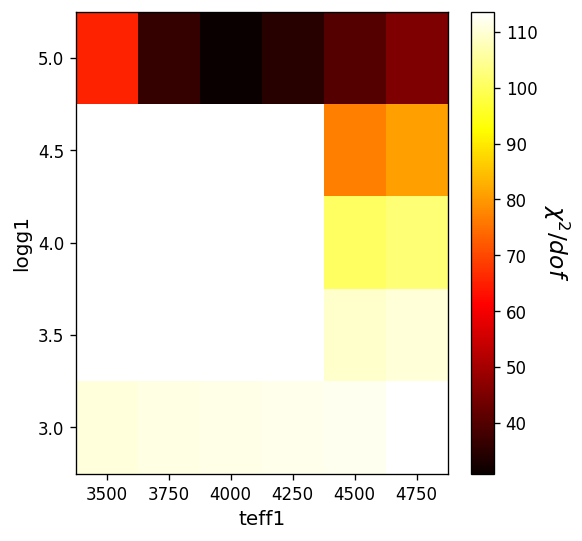

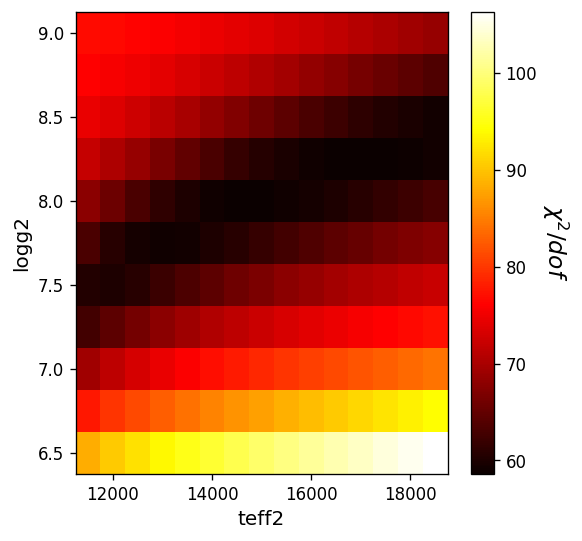

min chi2/dof = 7.5072668896094585
teff1 = 4500
logg1 = 4.5
teff2 = 14000
logg2 = 7.0
meta = 0.2
alpha = 0.0


In [62]:
teff1 = results[np.argmin(results['chi2'])]['teff1']
logg1 = results[np.argmin(results['chi2'])]['logg1']
teff2 = results[np.argmin(results['chi2'])]['teff2']
logg2 = results[np.argmin(results['chi2'])]['logg2']
meta = results[np.argmin(results['chi2'])]['meta']
alpha = results[np.argmin(results['chi2'])]['alpha']

idx1 = np.logical_and(results['teff2'] == teff2, results['logg2'] == logg2)
subset1 = results[idx1]
idx2 = np.logical_and(subset1['meta'] == meta, subset1['alpha'] == alpha)
subset2 = subset1[idx2]

plot_2d_heatmap(subset2,'teff1','logg1',6,False)


idx1 = np.logical_and(results['teff1'] == teff1, results['logg1'] == logg1)
subset1 = results[idx1]
idx2 = np.logical_and(subset1['meta'] == meta, subset1['alpha'] == alpha)
subset2 = subset1[idx2]

plot_2d_heatmap(subset2,'teff2','logg2',6,False)
print(f'min chi2/dof = {np.min(results["chi2"].astype(float)/(results["dof"].astype(float) - 6))}')
print(f'teff1 = {teff1}')
print(f'logg1 = {logg1}')
print(f'teff2 = {teff2}')
print(f'logg2 = {logg2}')
print(f'meta = {meta}')
print(f'alpha = {alpha}')

In [33]:
m1, m1_err = float(target_tbl[idx]['m1']),float(target_tbl[idx]['m1_err'])
m2, m2_err = float(target_tbl[idx]['m2']),float(target_tbl[idx]['m2_err'])
parallax, parallax_err = float(target_tbl[idx]['parallax']),float(target_tbl[idx]['parallax_err'])

m_tbl = model_flux(float(teff1),float(logg1),float(teff2),float(logg2),m1,m1_err,m2,m2_err,parallax,parallax_err,float(alpha),float(meta))
Table.sort(m_tbl,'wavelength')
o_tbl = deredden(target_tbl,idx)
Table.sort(o_tbl,'wavelength')

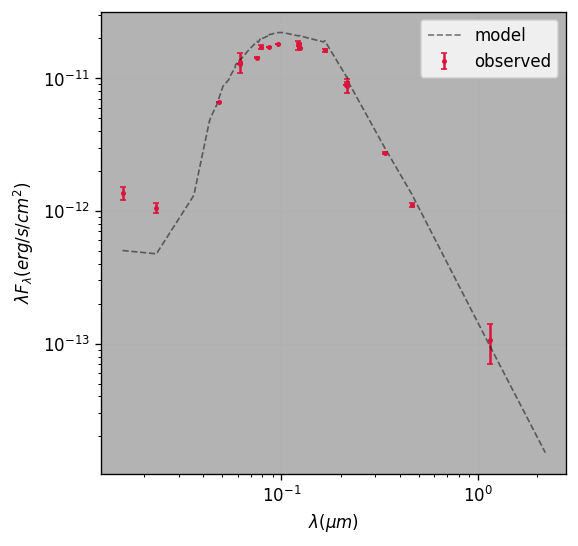

In [34]:
fig,ax = plt.subplots(figsize=(5,5),dpi=120)

ax.errorbar(o_tbl['wavelength']/1e5,np.multiply(o_tbl['flux_dereddened'],o_tbl['wavelength']),
            yerr=np.multiply(o_tbl['flux_dereddened_err'],o_tbl['wavelength']),linestyle='',color='Crimson',label='observed',capsize=2,marker='o',markersize=2)
# ax.errorbar(m_tbl['wavelength']/1e5,np.multiply(m_tbl['flux'],m_tbl['wavelength']),
            # yerr=np.multiply(m_tbl['flux_err'],m_tbl['wavelength']),linestyle='',color='k',label='model',capsize=2,alpha=0.5,linewidth=1,marker='o',markersize=2)
ax.plot(m_tbl['wavelength']/1e5,np.multiply(m_tbl['flux'],m_tbl['wavelength']),linestyle='--',color='k',label='model',alpha=0.5,linewidth=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda (\mu m) $')
ax.set_ylabel(r'$\lambda F_\lambda(erg/s/cm^2)$')
ax.set_facecolor('0.7')
ax.legend()
ax.grid()

# Summing different models

In [2]:
model = WD_models.load_model(low_mass_model='Bedard2020',
                             middle_mass_model='Bedard2020',
                             high_mass_model='ONe',
                             atm_type='H')

sources = Table.read('../table_hst.fits',format='fits')

In [3]:
filter_list = ['Obs.Flux_2MASS.H', 'Obs.Flux_2MASS.J', 'Obs.Flux_2MASS.Ks',
                'Obs.Flux_ACS_WFC.F606W', 'Obs.Flux_ACS_WFC.F814W',
                  'Obs.Flux_APASS.B', 'Obs.Flux_APASS.V',
                    'Obs.Flux_DECam.Y', 'Obs.Flux_DECam.g', 'Obs.Flux_DECam.i', 'Obs.Flux_DECam.r', 'Obs.Flux_DECam.z',
                      'Obs.Flux_DENIS.I', 'Obs.Flux_DENIS.J', 'Obs.Flux_DENIS.Ks',
                        'Obs.Flux_GAIA3.G', 'Obs.Flux_GAIA3.Gbp', 'Obs.Flux_GAIA3.Grp', 'Obs.Flux_GAIA3.Grvs',
                          'Obs.Flux_GALEX.FUV', 'Obs.Flux_GALEX.NUV',
                            'Obs.Flux_Johnson.B', 'Obs.Flux_Johnson.I', 'Obs.Flux_Johnson.R', 'Obs.Flux_Johnson.U', 'Obs.Flux_Johnson.V',
                              'Obs.Flux_PS1.g', 'Obs.Flux_PS1.i', 'Obs.Flux_PS1.r', 'Obs.Flux_PS1.y', 'Obs.Flux_PS1.z',
                                'Obs.Flux_SDSS.g', 'Obs.Flux_SDSS.i', 'Obs.Flux_SDSS.r', 'Obs.Flux_SDSS.u', 'Obs.Flux_SDSS.z',
                                  'Obs.Flux_UKIDSS.K',
                                    'Obs.Flux_VISTA.H', 'Obs.Flux_VISTA.J', 'Obs.Flux_VISTA.Ks', 'Obs.Flux_VISTA.Y',
                                      'Obs.Flux_WISE.W1', 'Obs.Flux_WISE.W2', 'Obs.Flux_WISE.W3']

ms_sed_logg_arr = np.arange(0,5.1,0.5)
wd_sed_logg_arr = np.arange(6.5,9.7,0.25)
meta_sed_arr = np.array([-2.5,2.0,-1.5,-1.0,-0.5,0.0,0.2,0.5])
ms_sed_teff_arr = np.hstack([np.arange(3500,13000,250),np.arange(13000,50001,1000)])
wd_sed_teff_arr = np.hstack([np.arange(5000,20000,250),np.arange(20000,30000,1000),np.arange(30000,40000,2000),np.arange(40000,50000,5000),np.arange(50000,80001,10000)])


def get_kurucz_sed_filepath(teff, logg, alpha, meta):
    ## 3500 <= teff <= 13000 with jumps of 250 (additional templates up to 50,000, but less dense)
    ## 0.0 <= logg <= 5.0 with jumps of 0.5
    ## alpha = 0 or alpha = 0.4
    ## -4.0 <= metallicity <= 0.5 evaluated at: -4.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.2, 0.5

    logg = ms_sed_logg_arr[np.argmin(np.abs(ms_sed_logg_arr - logg))]
    teff = ms_sed_teff_arr[np.argmin(np.abs(ms_sed_teff_arr - teff))]
    meta = meta_sed_arr[np.argmin(np.abs(meta_sed_arr - meta))]

    dirname = os.path.join('..','data','VOSA','models_MS','kurucz')
    filename = 'Kurucz2003all_f'
    if meta >= 0:
        filename += 'p'
    elif meta <= 0:
        filename += 'm'
    meta_dig1 = int((abs(meta)*10)//10)
    meta_dig2 = int((abs(meta)*10)%10)
    filename += f'{meta_dig1}{meta_dig2}'
    if alpha > 0:
        filename += 'a'
    filename += f't{int(teff)}'
    logg_dig1 = int((logg*10)//10)
    logg_dig2 = int((logg*10)%10)
    filename += f'g{logg_dig1}{logg_dig2}'
    filename += 'k2odfnew.fl.phot.xml'
    path = os.path.join(dirname,filename)
    if os.path.exists(path):
        return path
    elif os.path.exists(path.replace('all','')):
        return path.replace('all','')
    else:
        print('no such template ' + filename)
        return ''
    
def get_koester_sed_filepath(teff, logg):
    ## 5,000 <= teff <= 50,000 with jumps of 250
    ## 6.5 <= logg <= 9.0 with jumps of 0.25

    logg = wd_sed_logg_arr[np.argmin(np.abs(wd_sed_logg_arr - logg))]
    teff = wd_sed_teff_arr[np.argmin(np.abs(wd_sed_teff_arr - teff))]
    
    dirname = os.path.join('..','data','VOSA','models_WD','koester')
    filename = 'koester2_da'
    teff_dig1 = int((teff//10000)%10)
    teff_dig2 = int((teff//1000)%10)
    teff_dig3 = int((teff//100)%10)
    teff_dig4 = int((teff//10)%10)
    teff_dig5 = int((teff//1)%10)
    filename += f'{teff_dig1}{teff_dig2}{teff_dig3}{teff_dig4}{teff_dig5}_'
    filename += f'{int(logg*100)}'
    filename += '.dk.phot.xml'
    path = os.path.join(dirname,filename)
    if os.path.exists(path):
        return path
    else:
        # print('no such template ' + filename)
        return ''
    

def get_ms_logg(m, m_err):
    ## note to self- log g is defined as log_10 of g in cm/s^2

    ## use main sequence scaling relation: mass proportional to radius
    r = m * R_sun
    dr = m_err * R_sun
    g = G.value * m * M_sun.value / r**2 * 1e2 ## in cm/s^2
    dg = g * np.sqrt((2*dr/r)**2 + (2*m_err/m)**2)
    return np.log10(g.value)

def get_wd_logg(m,teff):
    ## WD radius nearly independent of mass
    m_logteff_to_logg = WD_models.interp_xy_z_func(x=model['mass_array'],
                                                  y=model['logteff'],
                                                  z=model['logg'],
                                                  interp_type='linear')
    logg = float(m_logteff_to_logg(m,np.log10(teff)))
    return logg

def model_sed_ms(teff1, m1, m1_err, parallax, parallax_err, meta1 = -0.5, alpha1 = 0):
    ## teff and logg are the parameters we wanna optimize (maybe alpha and meta too, one day)
    ## m (mass) and parallax should be given, to be used in the flux calculation
    if r1 == 0:
        logg1 = get_ms_logg(m1,m1_err)
    else:
        logg1 = np.log10(G.value * m1 * M_sun.value / (r1 * R_sun.value)**2 * 1e2)
    path1 = get_kurucz_sed_filepath(teff1, logg1, alpha1, meta1)
    if len(path1) == 0: ## wrong path: change directory path / check the parameters indeed have a template
        return Table({'filter':[], 'wavelength':[],'flux':[],'flux_err':[]}) 
    c1,dc1 = inverse_square_coeff(logg1,m1,m1_err,parallax,parallax_err)
    votable1 = parse(path1)
    table1 = Table.read(votable1.get_first_table())
    model_flux = c1 * table1['flux'].data * table1['wavelength'].data
    model_flux_err = dc1 * table1['flux'].data
    model_table = Table({'filter':table1['filter'].data, 'wavelength':table1['wavelength'].data,'flux':model_flux,'flux_err':model_flux_err})
    return model_table

def model_sed_wd(teff2,m2,m2_err,parallax,parallax_err):
      logg2 = get_wd_logg(m2,teff2)
      path2 = get_koester_sed_filepath(teff2, logg2)
      if len(path2) == 0: ## wrong path: change directory path / check the parameters indeed have a template
          return Table({'filter':[], 'wavelength':[],'flux':[],'flux_err':[]}) 
      c2,dc2 = inverse_square_coeff(logg2,m2,m2_err,parallax,parallax_err)
      votable2 = parse(path2)
      table2 = Table.read(votable2.get_first_table())
      model_flux = c2 * table2['flux'].data * table2['wavelength'].data
      model_flux_err = dc2 * table2['flux'].data
      model_table = Table({'filter':table2['filter'].data, 'wavelength':table2['wavelength'].data,'flux':model_flux,'flux_err':model_flux_err})
      return model_table

def plot_sed_ms_wd(teff1, m1, m1_err, teff2, m2, m2_err, parallax, parallax_err, meta1 = 0):
    ms = model_sed_ms(teff1, m1, m1_err, parallax, parallax_err, meta1)
    wd = model_sed_wd(teff2, m2, m2_err, parallax, parallax_err)
    ms.sort('wavelength')
    wd.sort('wavelength')
    
    tot_flux = ms['flux'] + wd['flux']

    fig , ax = plt.subplots(figsize=(5,5),dpi = 120)
    ax.plot(ms['wavelength'],ms['flux'],linestyle='--',color='RoyalBlue',label=f'MS {int(teff1)}K',linewidth=1,alpha=0.8)
    ax.plot(wd['wavelength'],wd['flux'],linestyle='--',color='Crimson',label=f'WD {int(teff2)}K',linewidth=1,alpha=0.8)
    ax.plot(ms['wavelength'],tot_flux,color='k',label=f'total flux',linewidth=1,marker='.',markersize=5)
    ax.scatter(ms['wavelength'][1],tot_flux[1],color='Indigo',s=50,label='Galex NUV',marker='o')
    ax.legend(loc = 'best')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\lambda (\AA) $',fontdict={'size':12})
    ax.set_ylabel(r'$\lambda F_\lambda(erg/s/cm^2)$',fontdict={'size':12})
    ax.set_facecolor('0.7')
    ax.set_ylim(1e-20,10*np.max(ms['flux']))
    ax.legend()
    ax.grid()
    fig.show()

def get_separatrix_fuv(m1,m2,excess):
    parallax = 1
    meta = 0
    
    x,y = np.meshgrid(ms_sed_teff_arr[ms_sed_teff_arr < 10000],wd_sed_teff_arr)
    j = 0
    teff2_f = []
    
    for i in tqdm(range(x.shape[1])):
        fuv_excess = 0
        while fuv_excess < excess and j < x.shape[0]:
            t1 = x[j][i]
            t2 = y[j][i]
            ms = model_sed_ms(t1, m1, m1 * 0.1, parallax, parallax * 0.1, meta)
            wd = model_sed_wd(t2, m2, m2 * 0.1, parallax, parallax * 0.1)
            try:       
                ms_fuv = ms[ms['filter'] == 'GALEX/GALEX.FUV']['flux'][0]
                wd_fuv = wd[wd['filter'] == 'GALEX/GALEX.FUV']['flux'][0]
                fuv_excess = 1 + wd_fuv / ms_fuv
            except:
                fuv_excess = 0
            j += 1
        if j < x.shape[0]:
            teff2_f.append(t2)
    return x[0,0:len(teff2_f)], np.array(teff2_f)
    

def get_separatrix_nuv(m1,m2,excess):
    parallax = 1
    meta = 0
    
    x,y = np.meshgrid(ms_sed_teff_arr[ms_sed_teff_arr < 10000],wd_sed_teff_arr)
    j = 0
    teff2_n = []
    
    for i in tqdm(range(x.shape[1])):
        nuv_excess = 0
        while nuv_excess < excess and j < x.shape[0]:
            t1 = x[j][i]
            t2 = y[j][i]
            ms = model_sed_ms(t1, m1, m1 * 0.1, parallax, parallax * 0.1, meta, r1 = r1)
            wd = model_sed_wd(t2, m2, m2 * 0.1, parallax, parallax * 0.1)
            try:       
                ms_nuv = ms[ms['filter'] == 'GALEX/GALEX.NUV']['flux'][0]
                wd_nuv = wd[wd['filter'] == 'GALEX/GALEX.NUV']['flux'][0]
                nuv_excess = 1 + wd_nuv / ms_nuv
            except:
                nuv_excess = 0
            j += 1
        if j < x.shape[0]:
            teff2_n.append(t2)
    return x[0,0:len(teff2_n)], np.array(teff2_n)

def plot_separatrix_nuv(excess,m1,m1_err,m2,m2_err,teff1,teff2):
    ## excess is: total flux / single star flux

    r1 = get_radius(get_ms_logg(m1,m1_err),m1,m1_err)[0] / R_sun.value
    r2 = get_radius(get_wd_logg(m2,teff2),m2,m2_err)[0] / R_sun.value
    x,y = get_separatrix_nuv(m1,m2,excess)
    fig,ax = plt.subplots(figsize=(5,5),dpi=120)
    ax.set_xlabel(r'$T_{eff,MS}$')
    ax.set_ylabel(r'$T_{eff,WD}$')    
    textstr = '\n'.join((f'$M_1 = {m1:.2f} M_\odot$' + f'$R_1 = {r1:.2f} R_\odot$',
                        f'$M_2 = {m2:.2f} M_\odot$' + f'$R_2 = {r2:.2f} R_\odot$'))
    props = dict(boxstyle='round', facecolor='DimGray',edgecolor='k',alpha = 0.8)
    ax.text(0.02, 0.8, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    ax.plot(x,y,label=f'{int((excess - 1)*100)}% NUV excess')
    
    ax.scatter(teff1,teff2,label='Current estimate',color='Crimson',marker='x',s=50)
    ax.legend(loc = [0.02,0.84],facecolor='DimGray',edgecolor='k')
    ax.grid()
    plt.show()

In [4]:
ms_logg_arr = np.array([3.5,4.0,4.5,5.0])
wd_logg_arr = np.arange(6.5,9.7,0.25)
meta_arr = np.array([-2.5,2.0,-1.5,-1.0,-0.5,0.0,0.2,0.5])
ms_teff_arr = np.hstack([np.arange(3500,13000,250),np.arange(13000,50001,1000)])
wd_teff_arr = np.hstack([np.arange(5000,20000,250),np.arange(20000,30000,1000),np.arange(30000,40000,2000),np.arange(40000,50000,5000),np.arange(50000,80000,10000)])

def get_kurucz_spec_filepath(teff, logg, meta):
    ## 3500 <= teff <= 50000 with jumps of 250 up to 13,000
    ## 3.5 <= logg <= 5.0 with jumps of 0.5
    ## -2.5 <= metallicity <= 0.5 evaluated at: -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.2, 0.5
    dirname = os.path.join('..','data','VOSA','spectra_MS','Kurucz')
    filename = 'f'

    logg = ms_logg_arr[np.argmin(np.abs(ms_logg_arr - logg))]
    meta = meta_arr[np.argmin(np.abs(meta_arr - meta))]
    teff = ms_teff_arr[np.argmin(np.abs(ms_teff_arr - teff))]

    if meta >= 0:
        filename += 'p'
    elif meta <= 0:
        filename += 'm'
    meta_dig1 = int((abs(meta)*10)//10)
    meta_dig2 = int((abs(meta)*10)%10)
    filename += f'{meta_dig1}{meta_dig2}'
    filename += 'k2odfnew.pck.teff='
    filename += f'{int(teff)}..logg='
    filename += f'{logg:0.5f}'
    filename += '.dat.xml'
    path = os.path.join(dirname,filename)
    if os.path.exists(path):
        return path
    else:
        print('no such template ' + filename)
        return ''
    
def get_koester_spec_filepath(teff, logg):
    ## 5,000 <= teff <= 80,000 with jumps of 250
    ## 7.0 <= logg <= 8.0 with jumps of 0.25
    dirname = os.path.join('..','data','VOSA','spectra_WD','Koester')
    filename = 'da'
    
    logg = wd_logg_arr[np.argmin(np.abs(wd_logg_arr - logg))]
    teff = wd_teff_arr[np.argmin(np.abs(wd_teff_arr - teff))]

    teff_dig1 = int((teff//10000)%10)
    teff_dig2 = int((teff//1000)%10)
    teff_dig3 = int((teff//100)%10)
    teff_dig4 = int((teff//10)%10)
    teff_dig5 = int((teff//1)%10)
    filename += f'{teff_dig1}{teff_dig2}{teff_dig3}{teff_dig4}{teff_dig5}_'
    filename += f'{int(logg*100)}'
    filename += '.dk.dat.xml'
    path = os.path.join(dirname,filename)
    if os.path.exists(path):
        return path
    else:
        print('no such template ' + filename)
        return ''

def get_radius(logg, m, m_err):
    ## calculate radius (in meters) from logg and the stellar mass (in units of M_sun)
    ## note to self- log g is defined as log_10 of g in cm/s^2
    r = np.sqrt(G.value * m * M_sun.value / (10**logg / 100))
    dr = r / (2*m) * m_err 
    return r , dr

def get_ms_logg(m, m_err):
    ## note to self- log g is defined as log_10 of g in cm/s^2

    ## use main sequence scaling relation: mass proportional to radius
    r = m * R_sun
    dr = m_err * R_sun
    g = G.value * m * M_sun.value / r**2 * 1e2 ## in cm/s^2
    dg = g * np.sqrt((2*dr/r)**2 + (2*m_err/m)**2)
    return np.log10(g.value) 

def get_wd_logg(m,teff):
    ## WD radius nearly independent of mass
    m_logteff_to_logg = WD_models.interp_xy_z_func(x=model['mass_array'],
                                                  y=model['logteff'],
                                                  z=model['logg'],
                                                  interp_type='linear')
    logg = float(m_logteff_to_logg(m,np.log10(teff)))
    return logg

def get_distance(parallax,parallax_err):
    ## distance in meters calculated from parallax in mas
    return (1000/parallax) * pc.value , (1000/parallax**2)*parallax_err * pc.value

def inverse_square_coeff(logg, m, m_err, parallax, parallax_err):
    R , dR = get_radius(logg, m, m_err)
    D , dD = get_distance(parallax, parallax_err)
    c = (R / D)**2
    dc = np.sqrt((2*(R/D**2)*dR)**2 + (2*(R**2/D**3)*dD)**2)
    return c , dc

def model_MS(teff1, m1, m1_err, parallax, parallax_err, meta1 = -0.5):
    ## teff and logg are the parameters we wanna optimize (maybe alpha and meta too, one day)
    ## m (mass) and parallax should be given, to be used in the flux calculation
    logg1 = get_ms_logg(m1,m1_err)
    path1 = get_kurucz_spec_filepath(teff1, logg1, meta1)
    if len(path1) == 0: ## wrong path: change directory path / check the parameters indeed have a template
        return Table({'wavelength':[],'wavelength':[]}) 
    c1,dc1 = inverse_square_coeff(logg1,m1,m1_err,parallax,parallax_err)
    votable1 = parse(path1)
    table1 = Table.read(votable1.get_first_table())
    model_flux = c1 * table1['FLUX'].data * table1['WAVELENGTH'].data
    model_table = Table({'wavelength':table1['WAVELENGTH'].data,'flux':model_flux})
    return model_table

def model_WD(teff2, m2, m2_err, parallax, parallax_err):
    ## teff and logg are the parameters we wanna optimize
    ## m (mass) and parallax should be given, to be used in the flux calculation
    logg2 = get_wd_logg(m2,teff2)
    path2 = get_koester_spec_filepath(teff2, logg2)
    if len(path2) == 0: ## wrong path: change directory path / check the parameters indeed have a template
        return Table({'wavelength':[],'flux':[]}) 
    c2,dc2 = inverse_square_coeff(logg2,m2,m2_err,parallax,parallax_err)
    votable2 = parse(path2)
    table2 = Table.read(votable2.get_first_table())
    model_flux = c2 * table2['FLUX'].data * table2['WAVELENGTH'].data
    model_table = Table({'wavelength':table2['WAVELENGTH'].data,'flux':model_flux})
    return model_table

def plot_binary_ms(teff1, m1, m1_err, teff2, m2, m2_err, parallax, parallax_err, meta1 = 0, meta2  = 0):
    ms1 = model_MS(teff1, m1, m1_err, parallax, parallax_err, meta1)
    ms2 = model_MS(teff2, m2, m2_err, parallax, parallax_err, meta2)
    ms1.sort('wavelength')
    ms2.sort('wavelength')

    shared_wl = np.union1d(ms1['wavelength'].data,ms2['wavelength'].data)
    m1_interp = np.interp(shared_wl,ms1['wavelength'].data,ms1['flux'].data, left = 0, right = 0)
    m2_interp = np.interp(shared_wl,ms2['wavelength'].data,ms2['flux'].data, left = 0, right = 0)
    
    tot_flux = m1_interp + m2_interp
    
    fig , ax = plt.subplots(figsize=(5,5),dpi = 120)
    ax.plot(ms1['wavelength'],ms1['flux'],linestyle='--',color='RoyalBlue',label=f'MS {int(teff1)}K',linewidth=1,alpha=0.8)
    ax.plot(ms2['wavelength'],ms2['flux'],linestyle='--',color='Crimson',label=f'MS {int(teff2)}K',linewidth=1,alpha=0.8)
    ax.plot(shared_wl,tot_flux,color='k',label=f'total flux',linewidth=1)
    ax.legend(loc = 'best')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\lambda (\AA) $',fontdict={'size':12})
    ax.set_ylabel(r'$\lambda F_\lambda(erg/s/cm^2)$',fontdict={'size':12})
    ax.set_ylim(1e-20,10*np.max(ms1['flux']))
    ax.set_facecolor('0.7')
    ax.legend()
    ax.grid()
    fig.show()

def plot_triple_ms(teff1, m1, m1_err, teff2, m2, m2_err, parallax, parallax_err, meta1 = 0, meta2  = 0):
    ms1 = model_MS(teff1, m1, m1_err, parallax, parallax_err, meta1)
    ms2 = model_MS(teff2, m2 / 2, m2_err, parallax, parallax_err, meta2)
    ms1.sort('wavelength')
    ms2.sort('wavelength')

    shared_wl = np.union1d(ms1['wavelength'].data,ms2['wavelength'].data)
    m1_interp = np.interp(shared_wl,ms1['wavelength'].data,ms1['flux'].data, left = 0, right = 0)
    m23_interp = np.interp(shared_wl,ms2['wavelength'].data,ms2['flux'].data, left = 0, right = 0)
    
    tot_flux = m1_interp + 2 * m23_interp
    
    fig , ax = plt.subplots(figsize=(5,5),dpi = 120)
    ax.plot(ms1['wavelength'],ms1['flux'],linestyle='--',color='RoyalBlue',label=f'MS {int(teff1)}K',linewidth=1,alpha=0.8)
    ax.plot(ms2['wavelength'],2 *ms2['flux'],linestyle='--',color='Crimson',label=f'double MS {int(teff2)}K',linewidth=1,alpha=0.8)
    ax.plot(m23_interp,tot_flux,color='k',label=f'total flux',linewidth=1)
    ax.legend(loc = 'best')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\lambda (\AA) $',fontdict={'size':12})
    ax.set_ylabel(r'$\lambda F_\lambda(erg/s/cm^2)$',fontdict={'size':12})
    ax.set_facecolor('0.7')
    ax.set_ylim(1e-20,10*np.max(ms1['flux']))
    ax.legend()
    ax.grid()
    fig.show()

def plot_binary_wd(teff1, m1, m1_err, teff2, m2, m2_err, parallax, parallax_err, meta1 = 0, gratings = ['galex']):
    ms = model_MS(teff1, m1, m1_err, parallax, parallax_err, meta1)
    wd = model_WD(teff2, m2, m2_err, parallax, parallax_err)
    ms.sort('wavelength')
    wd.sort('wavelength')
    
    shared_wl = np.union1d(ms['wavelength'].data,wd['wavelength'].data)
    m_interp = np.interp(shared_wl,ms['wavelength'].data,ms['flux'].data, left = 0, right = 0)
    w_interp = np.interp(shared_wl,wd['wavelength'].data,wd['flux'].data, left = 0, right = 0)
    tot_flux = m_interp + w_interp

    fig , ax = plt.subplots(figsize=(5,5),dpi = 120)
    ax.plot(ms['wavelength'],ms['flux'] ,linestyle='--',color='RoyalBlue',label=f'MS {int(teff1)}K',linewidth=1,alpha=0.8)
    ax.plot(wd['wavelength'],wd['flux'] ,linestyle='--',color='Crimson',label=f'WD {int(teff2)}K',linewidth=1,alpha=0.8)
    ax.plot(shared_wl,tot_flux,color='k',label=f'total flux',linewidth=1)
    if 800 in gratings:
        ax.vlines([815,1948],0,100,colors='Gold',lw=1,ls='--',label='COS G140L/800',alpha = 0.8)
    elif 1105 in gratings:
        ax.vlines([1118,2150],0,100,colors='Gold',lw=1,ls='--',label='COS G140L/1105',alpha = 0.8)
    if 2635 in gratings:
        ax.vlines([2435,2834],0,100,colors='Indigo',lw=1,ls='--',label='COS G230L/2635',alpha = 0.8)
    elif 'galex' in gratings:
        ax.vlines([1750,2800],0,100,colors='Indigo',lw=1,ls='--',label='GALEX NUV',alpha = 0.8)
    ax.legend(loc = 'best')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\lambda (\AA) $',fontdict={'size':12})
    ax.set_ylabel(r'$\lambda F_\lambda(erg/s/cm^2)$',fontdict={'size':12})
    ax.set_facecolor('0.7')
    ax.set_ylim(1e-20,10*np.max(ms['flux']))
    ax.legend()
    ax.grid()
    fig.show()
    return shared_wl, tot_flux / shared_wl ## wl in angstrom, flux in erg/s/cm^2/A

In [5]:
i = 4
sources = Table.read('../table_hst.fits',format='fits')

m1 = sources[i]['m1']
m1_err = sources[i]['m1_err']
m2 = sources[i]['m2']
if m2>1.25:
    m2 = sources[i]['m2'] - sources[i]['m2_err']
m2_err = sources[i]['m2_err']

parallax = sources[i]['parallax']
parallax_err = sources[i]['parallax_error']

teff1 = sources[i]['Teff1']
teff2 = sources[i]['Teff2']

meta = sources[i]['mh_for_mass_interp']

wl, fl = plot_binary_wd(teff1,m1,m1_err,teff2,m2,m2_err,parallax,parallax_err,meta,gratings = [800])
# plot_sed_ms_wd(teff1,m1,m1_err,teff2,m2,m2_err,parallax,parallax_err,meta)
# plot_binary_ms(8000,m1,m1_err,6000,m2,m2_err,parallax,parallax_err)
# plot_triple_ms(9000,m1,m1_err,3500,m2,m2_err,parallax,parallax_err)


# tbl = Table({'wavelength':wl,'flux':fl})
# cond = (tbl['wavelength'] > 925) & (tbl['wavelength'] < 80000)
# tbl = tbl[cond]
# tbl.write('../SBA28.dat',format='ascii',overwrite=True)

In [ ]:
sources[1]['sour']

In [7]:
# from dust_extinction.parameter_averages import G23
# import astropy.units as u

# ext = G23(Rv = 3.1)

# fuv_m0 = 18.82 # AB mag
# nuv_m0 = 20.08 # AB mag
# fuv_f0 = 1.4e-15 # erg/s/cm^2/A
# nuv_f0 = 2.06e-16 # erg/s/cm^2/A

# f_excess = []
# n_excess = []

# for i in range(len(sources)):
#     av = sources[i]['av_for_mass_interp']
#     m1 = sources[i]['m1']
#     m1_err = sources[i]['m1_err']
#     parallax = sources[i]['parallax']
#     parallax_err = sources[i]['parallax_error']
#     teff1 = sources[i]['Teff1']
#     meta = sources[i]['mh_for_mass_interp']
#     nuv_mag = sources[i]['nuv_mag']
#     fuv_mag = sources[i]['fuv_mag']

#     observed_nuv = 10**(-0.4 * (nuv_mag - nuv_m0)) * nuv_f0
#     observed_fuv = 10**(-0.4 * (fuv_mag - fuv_m0)) * fuv_f0

#     ms = model_sed_ms(teff1,m1,m1_err,parallax,parallax_err, meta)
#     wl_n = ms[ms['filter'] == 'GALEX/GALEX.NUV']['wavelength'][0]
#     model_nuv = ms[ms['filter'] == 'GALEX/GALEX.NUV']['flux'][0] / wl_n
#     model_nuv *= ext.extinguish(wl_n * u.AA ,Av=av)
#     n_excess.append(observed_nuv / model_nuv)

#     wl_f = ms[ms['filter'] == 'GALEX/GALEX.FUV']['wavelength'][0]
#     model_fuv = ms[ms['filter'] == 'GALEX/GALEX.FUV']['flux'][0] / wl_f
#     model_fuv *= ext.extinguish(wl_f * u.AA ,Av=av)
#     f_excess.append(observed_fuv / model_fuv)

# print(n_excess)
# print(f_excess)

[4.135635793343776, 0.5235170273851025, 2.334866859623821, 1.3938757595079896, 1.5231411681219156, masked]
[masked, masked, masked, masked, masked, 124.59903412691156]
